# SPMTs

SPMTs are Self-Propelled Modular Transporters. Also known as trailers. They are typically used to transport large and/or heavy loads over land.

An SPMT has two wheels per axle. The axles are hydraulically supported. The hydraulics of multiple axles are connected to create hydraulic groups. All axles in the same hydraulic group have the same hydraulic pressure and thus the same axle force. At least three hydraulic groups are required to carry a load in a stable way.

More info on SPMTs: [BEST PRACTICE GUIDE FOR SELF-PROPELLED MODULAR TRANSPORTER](https://estaeurope.eu/wp-content/uploads/2021/07/ESTA-BPG-SPMT-UK.pdf)

## SPMTs in DAVE

In DAVE a hydraulic group can be modelled using a SPMT node. This node models the axles and wheels of the group using a contact model. To model a SPMT the following nodes are needed:

1. A Frame or Body to attach the axles/wheels to
2. A contact-shape that the wheels can contact
3. The SPMT node itself

The locations of the axles of the SPMT are centered around the origin of the frame or body that they are located on. This means that every group of wheels should have its own parent Frame.

The equal force in the axles is derived from the compression of the hydraulics relative to its reference situation. This is a linear elastic relation and is defined using three settings:

1. Reference extension
2. Reference force
3. Stiffness

If all bottoms of all wheels are located `reference extension` below the SPMT origin then each axle carries the reference-force divided by the number of axles. So if the reference extension is 1.5m, the SPMT has 8 axles and the reference force is 800 kN then each axle carries 800/8=100 kN.
If *one* of the axles is moved upwards by 1m then the total force increases by `stiffness`.

## Example

In this example we make one SPMT. Because this is unstable we will give the load only a single degree of freedom (z).

First we make the SPMT body and the ground. For the ground we use the 'plane.obj' resource which is a 1x1 plane. We scale it by 10 in the horizontal directions.

In [1]:
%%capture
from DAVE import *
from DAVE.jupyter import show

In [2]:
s = Scene()

# code for SPMT_body
s.new_rigidbody(name='SPMT_body',  mass=10.0,
                fixed =(True, True, False, True, True, True) )

# code for ground
mesh = s.new_contactmesh(name='ground')
mesh.trimesh.load_file(r'res: plane.obj', scale = (10.0,10.0,1.0))

Now add the SPMT wheels

In [3]:
# code for SPMTs
spmt = s.new_spmt(name='SPMTs',
           parent='SPMT_body',
           reference_force = 10 * s.g,
           reference_extension = 1.5,
           k = 1000.0,
           n_length = 4,
           n_width = 2);

The reference force is 10xg and the reference extension is 1.5m. Since the mass of the SPMT_body is also 10mT we expect the resulting extension to be 1.5m (= the reference extension).

 Warning! Please use "settings.use_parallel_projection" instead!


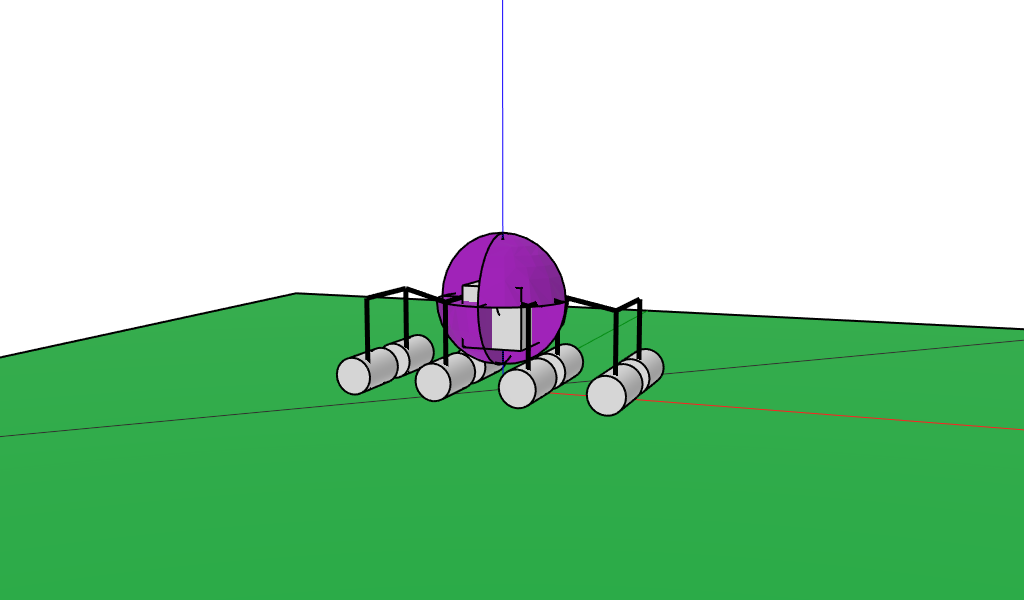

C:\python\miniconda3\envs\book\lib\site-packages\DAVE\jupyter\jupyter.py:194: UserWarning: VTK/Vedo issue: plotter is None
  warnings.warn("VTK/Vedo issue: plotter is None")


In [4]:
s.solve_statics()
show(s, camera_pos = (6.47, -16.862, 3.82),
     lookat = (-0.13, 0.77, 1.38))

There are 4 axles in length and 2 in width. Each axle should carry 1/8th of the load. Let's see if that is what we get.

In [5]:
spmt.extensions

(1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181,
 1.5000000078973181)

In [6]:
spmt.force

12.25831151283524

The stiffness is 1000 kN/m.

This is the TOTAL stiffness of all axles combined. Adding a load of 1000 kN will lower the whole SPMT by 1m.

Check elevation before:

In [7]:
s['SPMT_body'].gz

1.5000000078973181

Increase the weight by 1000 kN

In [8]:
s['SPMT_body'].mass = s['SPMT_body'].mass + 1000 / s.g

In [9]:
s.solve_statics()
s['SPMT_body'].gz

0.4999999565351737

The contact forces and extensions of the axles have changed similarly:

In [10]:
spmt.extensions

(0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365,
 0.49999995653517365)

In [11]:
spmt.force

137.2583179331033

Changing the reference-force to the updated load will cause the extensions to go back to 1.5m

In [12]:
spmt.reference_force = s.g * s['SPMT_body'].mass
s.solve_statics()
spmt.extensions

(1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606,
 1.5000000207274606)

## Friction

If the SPMT is placed on a slope then it will move down-hill unless it is movement is restrained.

Make the same model as above except now with:
- the ground under a 30 degree angle,
- movement and yaw of the SPMT allowed.

In [13]:
s = Scene()

# code for SPMT_body
s.new_rigidbody(name='SPMT_body',  mass=10.0,
                fixed =(False, False, False, True, True, False) )

# code for ground
mesh = s.new_contactmesh(name='ground')
mesh.trimesh.load_file(r'res: plane.obj', scale = (10.0,10.0,1.0), rotation = (0,30,0))

# code for SPMTs
spmt = s.new_spmt(name='SPMTs',
           parent='SPMT_body',
           reference_force = 10 * s.g,
           reference_extension = 1.5,
           k = 1000.0,
           n_length = 4,
           n_width = 2)


Attach the SPMT to a pole with a cable to keep it from rolling off the world (that would be unfortunate).

 Warning! Please use "settings.use_parallel_projection" instead!


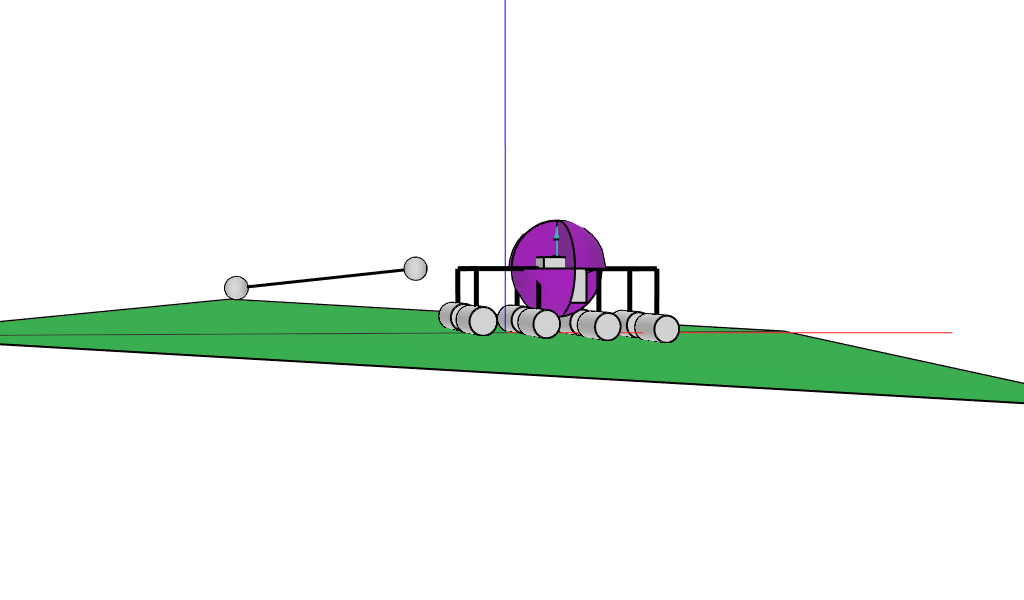

In [14]:
# code for Paaltje
s.new_point(name='Paaltje',
          position=(-6.0,
                    0.0,
                    1.0))
# code for Point
s.new_point(name='Point',
          parent='SPMT_body',
          position=(-3.0,
                    1.0,
                    0.0))
# code for cable
s.new_cable(name='cable',
            endA='Point',
            endB='Paaltje',
            length=4.0,
            EA=1000.0)

s.solve_statics()

show(s, camera_pos = (0.12732753037397992, -25, 1.3551851562852333),
     lookat = (0.1520424970484009, 0.40149863545755565, 0.7234384569499813),
     painters = 'Construction',
     zoom_fit = False)

Surprisingly the SPMT stays in place! The cable remains slack.

This is because by default the wheels have friction. Friction is modelled by restricting the force between the wheels and the contact-plane to be vertical. This is independent of the inclination of the SPMT and contact surface. The reasoning behind this model is that SPMTs are typically used to carry a load and therefore usually only subjected to purely vertical gravity loads.

Friction can be disabled. If friction is disabled then the contact-force is perpendicular to the contact surface.

 Warning! Please use "settings.use_parallel_projection" instead!


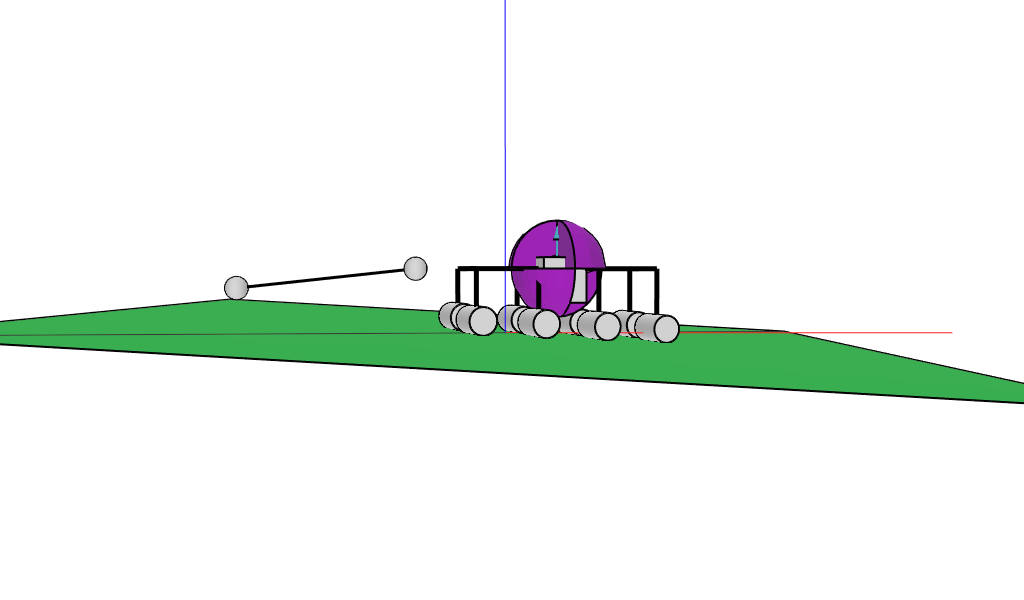

In [15]:
spmt.use_friction = False

s.solve_statics()

show(s, camera_pos = (0.12732753037397992, -25, 1.3551851562852333),
     lookat = (0.1520424970484009, 0.40149863545755565, 0.7234384569499813),
     painters = 'Construction',
     zoom_fit = False)


 Warning! Please use "settings.use_parallel_projection" instead!


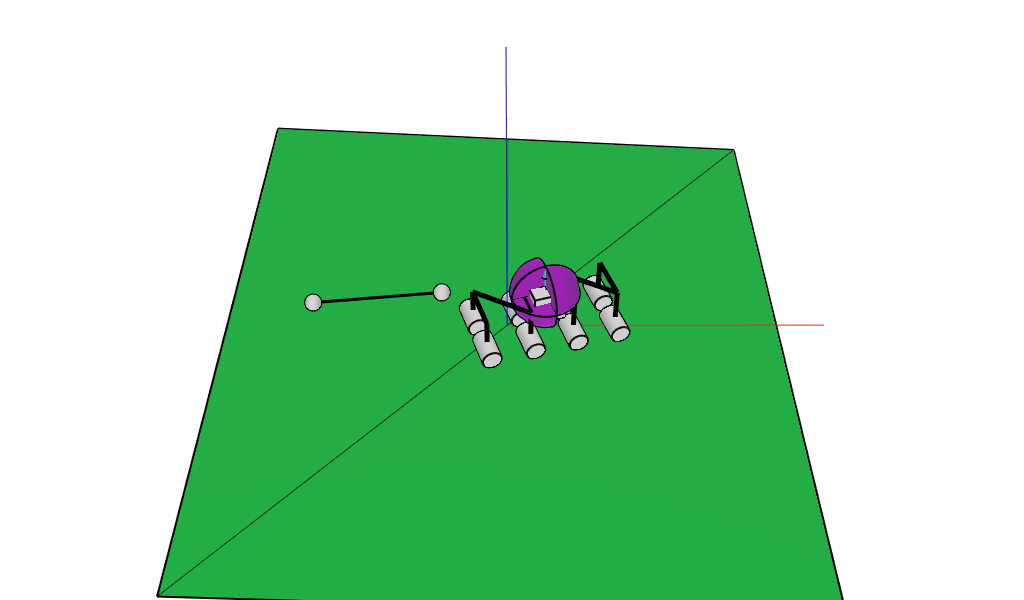

In [16]:
show(s, camera_pos = (0.12732753037397992, -25, 25),
     lookat = (0.1520424970484009, 0.40149863545755565, 0.7234384569499813),
     painters = 'Construction',
     zoom_fit = False)


Contact forces:

In [17]:
spmt.contact_force

[(0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, -0.0, 12.335288611464629),
 (0.7121782622280447, 0.0, 12.335288611464629)]

## Example with multiple groups and a surfaces

This example shows how to model multiple hydraulic groups below a cargo.

The origin of the cargo is chosen to be at the bottom, center. The CoG is 5m above that.

In [18]:
s = Scene()
cargo = s.new_rigidbody('cargo', mass = 100, cog = (0,0,5), fixed=(True,True, False,False,False,False))


The cargo is fixed in the horizontal plane but is free to rotate and move up and down.

Define three SPMTs. Connect them to cargo by placing them on cargo.

For each SPMT we define
1. the SPMT body [Frame or RigidBody]
2. the SPMT hydraulic group [SPMT]

In this example a rigidbody is used for the trailers. This gives the possibility to add the weight of the trailer itself.
The first group is placed on cargo at a position of 10,0,0.

In [19]:
s.new_rigidbody('Trailer1',parent = cargo, position = (10,0,0), mass = 1)

# Now add the wheels, by default this is a 4x2 set
s.new_spmt('Wheels1',parent='Trailer1');

The second and third trailers are defined similarly. These are placed 10m behind the center and 10m apart.

In [20]:
s.new_rigidbody('Trailer2',parent = cargo, position = (-10,5,0), mass = 1)
s.new_spmt('Wheels2',parent='Trailer2')

s.new_rigidbody('Trailer3',parent = cargo, position = (-10,-5,0), mass = 1)
s.new_spmt('Wheels3',parent='Trailer3');

For the floor we use a curved plane and a ramp:

In [21]:
mesh = s.new_contactmesh(name='Contactmesh1')
mesh.trimesh.load_file(r'res: plane_curved.stl', rotation = (0,5,0), scale = (10.0,10.0,1.0))

# code for Contactmesh
mesh = s.new_contactmesh(name='Contactmesh2')
mesh.trimesh.load_file(r'res: plane.obj', scale = (10.0,10.0,1.0), rotation = (0.0,-30.0,0.0), offset = (15.0,0.0,0.0))

 Warning! Please use "settings.use_parallel_projection" instead!


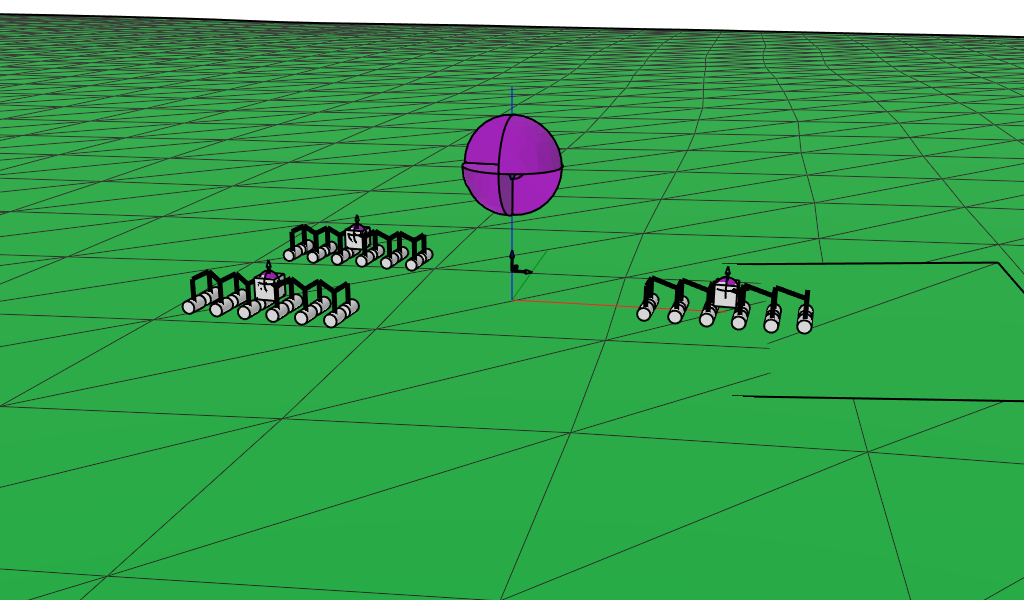

In [22]:
s.solve_statics()
show(s, camera_pos=(10,-50,15))

## Extensions and forces on a sloped surface

The extensions of the individual axles are all calculated individually:

In [23]:
s['Wheels1'].extensions

(1.4984898378742275,
 1.5041629741472944,
 1.49686560841721,
 1.502538744690277,
 1.5074017439519127,
 1.5009145152332592,
 1.5156255460979586,
 1.515439542404467,
 1.5222967334149837,
 1.5176225379792527,
 1.4314938484805708,
 1.4268196530448403)

but, when using friction, the contact force is the same for all of them:

In [24]:
s['Wheels1'].contact_force

[(0.26387108380497976, 0.09129449205184322, 41.894358855688736),
 (0.26387108380497976, 0.09129449205184322, 41.894358855688736),
 (0.26387108380497976, 0.09129449205184322, 41.894358855688736),
 (0.26387108380497976, 0.09129449205184322, 41.894358855688736),
 (0.5445606621905643, -0.10031875679905096, 41.89200423277038),
 (0.26387108380497976, 0.09129449205184322, 41.894358855688736),
 (0.5445606621905643, -0.10031875679905096, 41.89200423277038),
 (0.5445606621905643, -0.10031875679905096, 41.89200423277038),
 (-2.419870711961842, 0.0, 41.913387725560185),
 (-2.419870711961842, 0.0, 41.913387725560185),
 (-2.419870711961842, 0.0, 41.913387725560185),
 (-2.419870711961842, 0.0, 41.913387725560185)]

This changes when friction is disabled.

## Shear and moment diagrams

The forces at the wheels are discrete forces and do appear as such in the load, shear and moment diagrams. Both on the SPMT and the contact-surface sides.
This means that for load-outs the individual axle loads are present the shear and bending moments in the barge and trailers.

[Video](https://youtu.be/2e6zUmVgV-Q)

In [25]:
trailer = s['Trailer1']

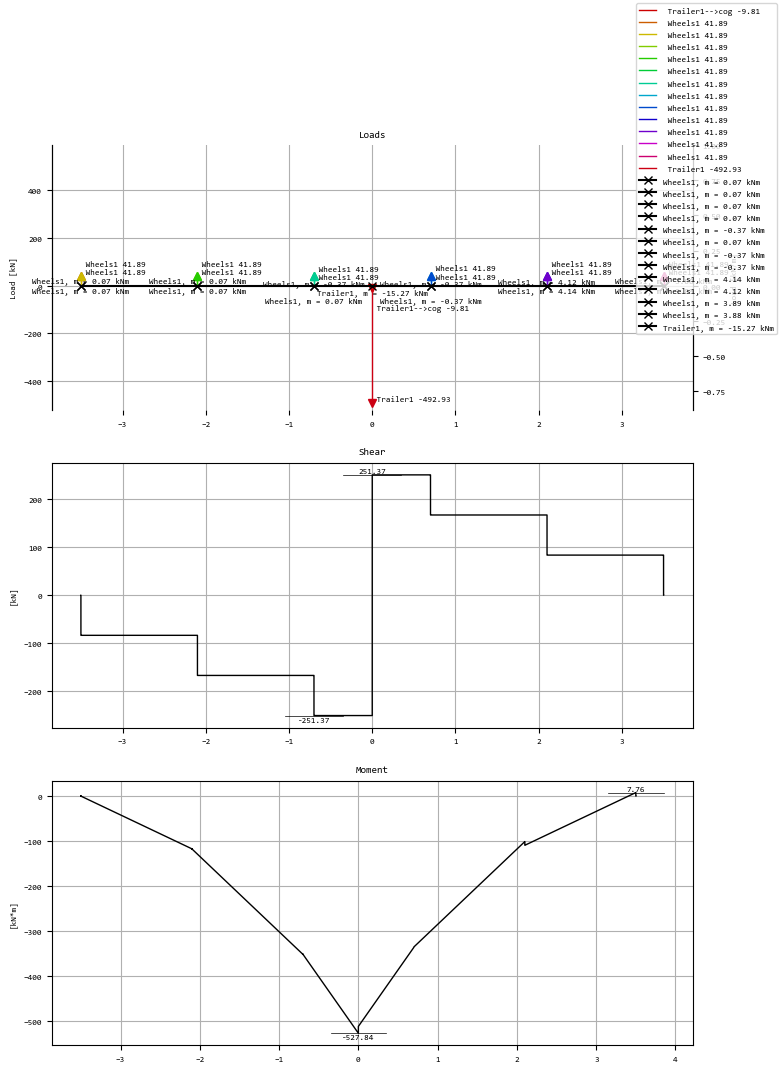

In [26]:
trailer.give_load_shear_moment_diagram().plot();